In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import scipy
from lmfit import Model
from IPython.display import display

def find_nearest(value, array):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def func(x, c0, c1, c2, t1, t2, rr):
    return c0 + c1*np.exp(-np.abs(x)/t1) * ( c2*np.exp(-np.abs(x)/t2) + ( np.exp(-np.abs(x+1*rr)/t2) + np.exp(-np.abs(x-1*rr)/t2)) ) # with c0 and rr
    # return c1*np.exp(-np.abs(x)/t1) * ( c2*np.exp(-np.abs(x)/t2) + ( np.exp(-np.abs(x+1*1)/t2) + np.exp(-np.abs(x-1*1)/t2)) ) # without c0 and rr
    # return (c2**2*np.exp(-np.abs(x)/t2**2)+c1**2*(np.exp(-np.abs(x+1*rr**2)/t2**2)+np.exp(-np.abs(x-1*rr**2)/t2**2))) # without c0 and t1, vars squared


Duplicate key in file '/Users/andrewproppe/.matplotlib/matplotlibrc' line #3.
Duplicate key in file '/Users/andrewproppe/.matplotlib/matplotlibrc' line #4.


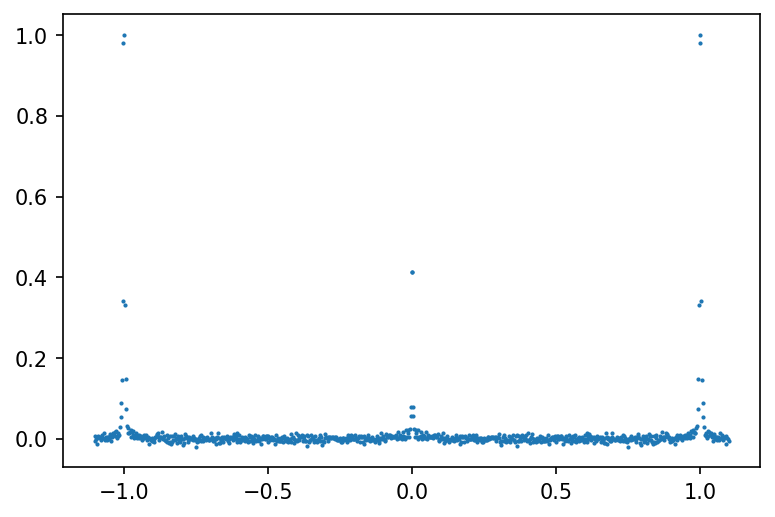

In [2]:
# Real data
g2Data = pd.read_excel('/Users/andrewproppe/Bawendi_Lab/g2_fitting/tara_g2s.xlsx')
xData    = g2Data.time*1e6
yData    = g2Data.g2_100
bckgrnd  = np.sum(yData[find_nearest(0.5,xData)-20:find_nearest(0.5,xData)+20])/40 # Grab points around t = 0.5 µs and subtract; crude background subtraction estimate
yData    = yData - bckgrnd
yData    = yData / np.max(yData) # normalize side peak to 1

fig1 = plt.figure(1, dpi=150,figsize=(6,4))
x = np.array(xData)
y = np.array(yData)

# # Dummy data
# ydummy = func(x, 1.27, 0.49, 0.1, 1)
# y = ydummy / np.max(ydummy)

plt.plot(x,y,'o',markersize=1)

parameter names: ['c0', 'c1', 'c2', 't1', 't2', 'rr']
independent variables: ['x']
{'c0': 0.001732080555773799, 'c1': 1.6395841714580177, 'c2': 0.23753928397364465, 't1': 9999976583.03655, 't2': 0.002458228692322665, 'rr': 0.9999838038500707}


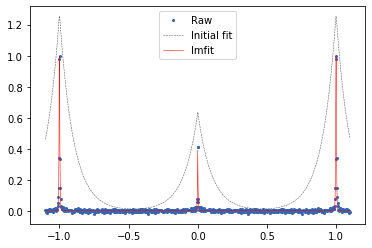

In [5]:
fmodel = Model(func)
print('parameter names: {}'.format(fmodel.param_names))
print('independent variables: {}'.format(fmodel.independent_vars))

params = fmodel.make_params()
params['c0'].set(value=0, min=-0.05, max=+0.05)
params['c1'].set(value=1.27, min=0, max=2)
params['c2'].set(value=0.5, min=0, max=1)
params['t1'].set(value=1e4, min=1e2, max=1e10)
params['t2'].set(value=5e-1, min=1e-4, max=1e-1)
params['rr'].set(value=1, min=0.95, max=1.05)

result = fmodel.fit(y, params, x=x, method='Powell')
model_error = np.abs(result.best_fit - y)

plt.plot(x, y, 'o', color=[0.2, 0.4, 0.7], markersize=2, label='Raw')
plt.plot(x, result.init_fit, '--', linewidth=0.5, color=[0.3, 0.3, 0.3], label='Initial fit')
plt.plot(x, result.best_fit, 'r-', linewidth=0.5, label='lmfit')
plt.legend(loc='best')
print(result.values)

Finding MAP...


/Users/andrewproppe/opt/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:132: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "


Optimization terminated successfully.
         Current function value: 808.726596
         Iterations: 1
         Function evaluations: 86
MAP found


/Users/andrewproppe/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:470: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Sequential sampling (2 chains in 1 job)
NUTS: [rr, t2, t1, c2, c1, c0]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 68 seconds.


Plotting traces...


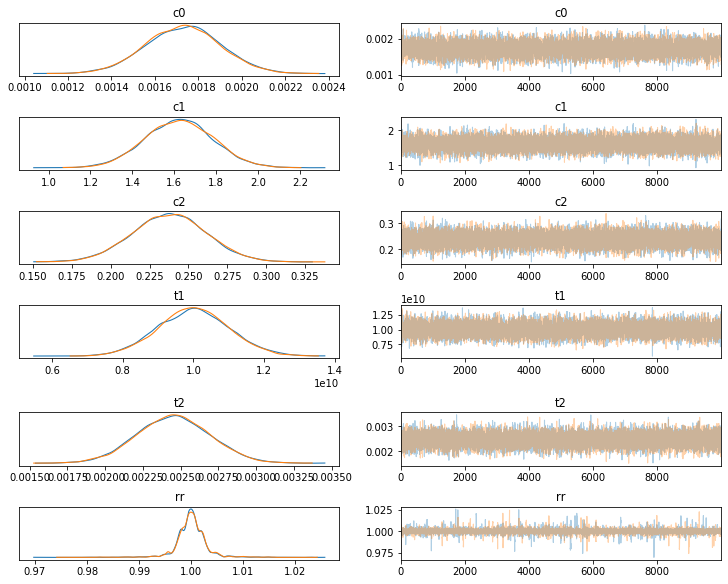

In [6]:
with pm.Model() as model:

    # Enter values manually
    # c1 = pm.Normal('c1', mu=1.27, sigma=0.1, testval=result.values['c1'].item())
    # c2 = pm.Normal('c2', mu=0.5, sigma=0.1, testval=result.values['c2'].item())
    # t2 = pm.Normal('t2', mu=5e-2, sigma=0.01, testval=result.values['t2'].item())

    # Use best values from lmfit
    c0 = pm.Normal('c0', mu=result.values['c0'].item(), sigma=result.values['c0'].item()*0.1, testval=result.values['c0'].item())
    c1 = pm.Normal('c1', mu=result.values['c1'].item(), sigma=result.values['c1'].item()*0.1, testval=result.values['c1'].item())
    c2 = pm.Normal('c2', mu=result.values['c2'].item(), sigma=result.values['c2'].item()*0.1, testval=result.values['c2'].item())
    t1 = pm.Normal('t1', mu=result.values['t1'].item(), sigma=result.values['t1'].item()*0.1, testval=result.values['t1'].item())
    t2 = pm.Normal('t2', mu=result.values['t2'].item(), sigma=result.values['t2'].item()*0.1, testval=result.values['t2'].item())
    rr = pm.Normal('rr', mu=result.values['rr'].item(), sigma=result.values['rr'].item()*0.01, testval=result.values['rr'].item())

    # fit = pm.Deterministic('fit', ( c2**2*np.exp(-np.abs(x)/t2**2)+c1**2*(np.exp(-np.abs(x+1*rr**2)/t2**2)+np.exp(-np.abs(x-1*rr**2)/t2**2)) )) # vars squared
    fit = pm.Deterministic('fit', ( c0 + c1 * np.exp(-np.abs(x) / t1) * (c2 * np.exp(-np.abs(x) / t2) + (np.exp(-np.abs(x + 1 * rr) / t2) + np.exp(-np.abs(x - 1 * rr) / t2))) )) # vars squared

    y_pymc = pm.Normal('y', mu=fit, observed=y)
    # y_pymc = pm.Poisson('y', mu=fit, observed=y)

with model:
    print('Finding MAP...')
    start=pm.find_MAP(fmin=scipy.optimize.fmin_powell) # The MAP estimate works better here with Powell
    print('MAP found')
    step=pm.NUTS()
    # step=pm.Metropolis()
    trace=pm.sample(10000, cores=1, step=step, start=start)

with model:
    print('Plotting traces...')
    az.plot_trace(trace, var_names=["c0", "c1", "c2", "t1", "t2", "rr"], figsize=(10,8), divergences='auto')
    
# with model:
#     print('Displaying summary...')
#     display(az.summary(trace, round_to=2))    

In [ ]:
# with model:
#     print('Displaying summary...')
#     display(az.summary(trace, round_to=2))

# with model:
#     ppc = pm.sample_posterior_predictive(
#         trace, var_names=["c1", "c2", "t2", "rr", "obs"]
#     )
    
# # az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));    
# mu_pp = (ppc["c2"]**2*np.exp(-np.abs(x[:, None])/ppc["t2"]**2)+ppc["c1"]**2*(np.exp(-np.abs(x[:, None]+1*ppc["rr"]**2)/ppc["t2"]**2)+np.exp(-np.abs(x[:, None]-1*ppc["rr"]**2)/ppc["t2"]**2))).T

Text(0.5, 0, 'Time (µs)')

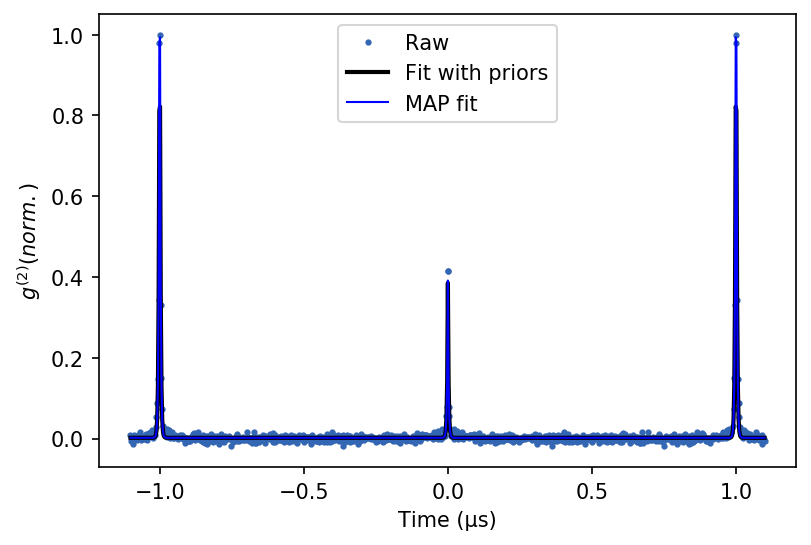

In [8]:
# extract and plot results
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

# plt.figure(1)
fig2 = plt.figure(1, dpi=150, figsize=(6, 4))
plt.plot(x, y, 'o', color=[0.2, 0.4, 0.7], markersize=2, label='Raw')
plt.plot(x, y_fit, 'k', linewidth=2, label='Fit with priors')
plt.plot(x, start['fit'], 'b', linewidth=1, label='MAP fit')
plt.legend()
plt.ylabel(r'$g^{(2)} (norm.)$')
plt.xlabel("Time (µs)")